In [18]:
import pandas as pd
import torch
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import tqdm

import config
from utils import CustomDataset, save_checkpoint, create_save_dir
import torch.optim.lr_scheduler as lr_scheduler

from pycalib.visualisations import plot_reliability_diagram
from pycalib.metrics import conf_ECE, classwise_ECE
from sklearn.isotonic import IsotonicRegression 
import glob
import pickle

random.seed(10)

# Load data and explore data
In the 'prepare_data.py' script, the data is randomly divided into a training set (80%) and a validation set (20%). This dataset comprises a total of 10 classes. However, there's an imbalance issue due to the unequal distribution of samples among these classes.


In [19]:
# load data
df = pd.read_csv("../data/train.csv")
train_imgs = pd.read_csv("../data/train_set_images.csv")
valid_imgs = pd.read_csv("../data/valid_set_images.csv")

# transform format of data
df['Image'] = df['Image'].astype(str) + ".png"

# df.drop('Label',inplace=True, axis=1)
df.rename(columns={"Image":"image"},inplace=True)
df.head()

,image,Label
0,12874.png,1 4
1,21466.png,0
2,3610.png,4
3,2095.png,2 4
4,28909.png,4


In [20]:
#split labels for train set and valid set
train_df = df[df['image'].isin(train_imgs['filenames'])]
valid_df = df[df['image'].isin(valid_imgs['filenames'])]

print(f"Number of image in train dataset: {len(train_df)}")
print(f"Number of image in validation dataset: {len(valid_df)}")

Number of image in train dataset: 12311
Number of image in validation dataset: 3078


In [21]:
# calculate the frequency of each class in training dataset
def calculate_freq(df_data):
    df = df_data.copy()
    df["label_0"] = df['Label'].apply(lambda x: 1 if "0" in x else 0)
    df["label_1"] = df['Label'].apply(lambda x: 1 if "1" in x else 0)
    df["label_2"] = df['Label'].apply(lambda x: 1 if "2" in x else 0)
    df["label_3"] = df['Label'].apply(lambda x: 1 if "3" in x else 0)
    df["label_4"] = df['Label'].apply(lambda x: 1 if "4" in x else 0)
    df["label_5"] = df['Label'].apply(lambda x: 1 if "5" in x else 0)
    df["label_6"] = df['Label'].apply(lambda x: 1 if "6" in x else 0)
    df["label_7"] = df['Label'].apply(lambda x: 1 if "7" in x else 0)
    df["label_8"] = df['Label'].apply(lambda x: 1 if "8" in x else 0)
    df["label_9"] = df['Label'].apply(lambda x: 1 if "9" in x else 0)
    freq = df.iloc[:,2:].sum().to_list()
    return freq
train_freq = calculate_freq(train_df)
train_pos_weight = len(train_df)/np.array(train_freq)-1

<Axes: xlabel='class', ylabel='freq'>

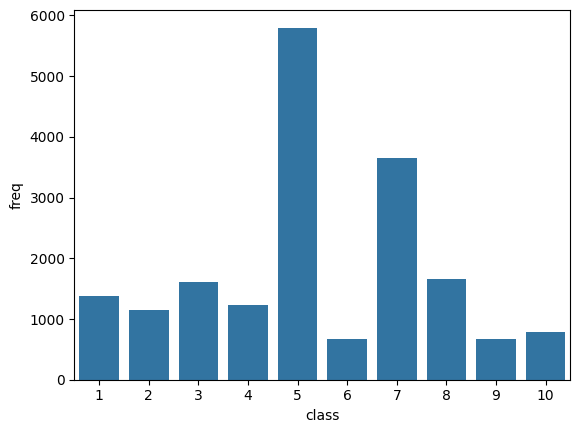

In [22]:
class_count = pd.DataFrame(zip(train_freq,list(range(1,11))), columns=['freq','class'])
sns.barplot(data=class_count, y='freq', x='class')

Observably, the bulk of samples belong to 'class 5' and 'class 7', totaling nearly 6000 each, whereas the remaining classes only have around 1000 samples. This significant imbalance can substantially impact the model's performance, potentially leading to increased bias towards 'class 5' and 'class 7'

# Training model
The training of the model utilizes a pre-trained ResNet34 architecture. This specific model expects input images to be sized at 224x224 pixels. The initial step in data preprocessing involves resizing the images to meet this requirement. Subsequently, the pixel values are scaled to a range between 0 and 1, followed by normalization. For the ResNet model to operate optimally, its inputs need to be normalized using a predefined mean and standard deviation (mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]), based on statistics from the ImageNet dataset used during its pretraining phase.

This normalization, derived from ImageNet's mean and standard deviation, serves as a crucial step in neural network training. It aids in stabilizing and expediting the training process by ensuring that input values conform to a standardized range.

To mitigate overfitting, we implement data augmentation by incorporating image rotation during the training process

The pre-trained model undergoes a process where the initial layer is frozen while the subsequent layers are unfrozen. This strategy aims to retain the fundamental context learned from the ImageNet dataset while enabling the model to adapt and grasp the specific characteristics present in the subsequent layers. The decision to solely freeze the first layer stems from the unique and distinct nature of cell images, markedly different from the broader context of images in ImageNet. By preserving the detailed features acquired from ImageNet, the model encounters challenges in effectively learning from the intricate nuances inherent in cell images.

To address the imbalance, I implement a weighted loss function. These adapted loss functions assign varying weights to different classes, tailoring the emphasis based on the degree of imbalance.



In [23]:
transform = {'train' :  transforms.Compose([
                    transforms.Resize(224),
                    transforms.RandomRotation(degrees=(0,30)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ]),
            'test' : transforms.Compose([
                    transforms.Resize(224),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])
            }

def data_loader(img_folder, df, nlabels, transform, is_train=True, with_label=True):

    dataset = CustomDataset(df, img_folder, transform['train' if is_train else 'test'], nlabels, with_label = with_label)
    dataset_loader = DataLoader(dataset=dataset, batch_size=config.BATCHSIZE, shuffle=True)
    return dataset_loader

# tranform data and load data into data loader

train_loader = data_loader(config.train_folder, train_df, config.N_LABELS, transform=transform)
valid_loader = data_loader(config.valid_folder, valid_df, config.N_LABELS, transform=transform, is_train=False)


In [24]:
# Prepare model architect; using resnet34
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
resnet.fc = nn.Linear(in_features=resnet.fc.in_features, out_features=10, bias=True)

# Freeze all layers
for param in resnet.parameters():
    param.requires_grad = False

# Unfreeze layer 2, 3, 4, and fc
for param in resnet.layer2.parameters():
    param.requires_grad = True
    
for param in resnet.layer3.parameters():
    param.requires_grad = True

for param in resnet.layer4.parameters():
    param.requires_grad = True

for param in resnet.avgpool.parameters():
    param.requires_grad = True

for param in resnet.fc.parameters():
    param.requires_grad = True

model = resnet


Using cache found in C:\Users\THU/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\THU\Anaconda3\envs\ml_project2_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\THU\Anaconda3\envs\ml_project2_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# prepare saving dir
output_dir = create_save_dir(config.model_dir, config.model_name)
writer = SummaryWriter(log_dir=output_dir/'runs')

loss_function = nn.BCEWithLogitsLoss(pos_weight=torch.from_numpy(train_pos_weight))
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # SGD = stochastic gradient descent
scheduler = lr_scheduler.LinearLR(optimizer, start_factor = 1, end_factor=0.1, total_iters=20)

m = nn.Sigmoid()
best_val = 10e7
for i in range(1, config.N_EPOCHS + 1):
    train_losses = []
    train_predictions = []
    train_labels = []
    model.train()
    with tqdm.tqdm(train_loader, unit="batch",position=0, leave=True) as tepoch:
        for X_batch, y_batch, img_name in tepoch:
            tepoch.set_description(f"Training {i}/{int(config.N_EPOCHS)}")
            optimizer.zero_grad()
            
            y_hat_batch = model(X_batch)

            loss = loss_function(y_hat_batch, y_batch) # Compute loss

            loss.backward()   # Calculate gradients
            optimizer.step()   # Update weights using defined optimizer

            train_losses.append(loss.item())
            tepoch.set_postfix(loss=loss.item())
            train_predictions.append(m(y_hat_batch))
            train_labels.append(y_batch)

    before_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    after_lr = optimizer.param_groups[0]["lr"]
    print("Epoch %d: lr %.4f -> %.4f" % (i, before_lr, after_lr))
    avg_train_loss = np.mean(train_losses)

    train_predictions = torch.cat(train_predictions)
    train_pred_labels = (train_predictions>=config.pred_threshold).long()
    train_labels = torch.cat(train_labels)

    train_metrics = classification_report(train_labels,train_pred_labels,output_dict=True,zero_division=0)
    train_macro_f1_score = train_metrics['macro avg']['f1-score']

    print(i, '\t', avg_train_loss, end="   ")
    print(f"Recall: {train_metrics['macro avg']['recall']}", end="    ")
    print(f"Precision: {train_metrics['macro avg']['precision']}", end="  ")
    print(f"F1-score: {train_macro_f1_score}", end="  ")

    predictions = []
    true_labels = []
    valid_losses = []

    with torch.no_grad():
        model.eval()
        with tqdm.tqdm(valid_loader, unit="batch",position=0, leave=True) as tepoch:
            for X_batch, y_batch, img_name in tepoch:
                tepoch.set_description(f"Evaluating {i}/{int(config.N_EPOCHS)}")

                y_hat_batch =  model(X_batch) #m(model(X_batch))

                loss = loss_function(y_hat_batch, y_batch)

                valid_losses.append(loss.item())
                predictions.append(m(y_hat_batch))
                true_labels.append(y_batch)

                tepoch.set_postfix(loss=loss.item())
    
    avg_valid_loss = np.mean(valid_losses)

    predictions = torch.cat(predictions)
    pred_labels = (predictions>=config.pred_threshold).long()
    true_labels = torch.cat(true_labels)

    metrics = classification_report(true_labels,pred_labels,output_dict=True,zero_division=0)
    macro_f1_score = metrics['macro avg']['f1-score']
    # print result
    print(i, '\t', avg_valid_loss, end="   ")
    print(f"Recall: {metrics['macro avg']['recall']}", end="    ")
    print(f"Precision: {metrics['macro avg']['precision']}", end="  ")
    print(f"F1-score: {macro_f1_score}", end="  ")

    # write plot using tensorboard
    writer.add_scalars('loss', {'train':avg_train_loss,
                                'val':avg_valid_loss},i)
    
    writer.add_scalars(f'recall', {'train':train_metrics['macro avg']['recall'],
                            'val':metrics['macro avg']['recall']},i)
    writer.add_scalars(f'precision',{'train':train_metrics['macro avg']['precision'],
                            'val':metrics['macro avg']['precision']},i)
    writer.add_scalars(f'f1', {'train':train_metrics['macro avg']['f1-score'],
                            'val':metrics['macro avg']['f1-score']},i)
    
    for key, label in config.labels.items():
        writer.add_scalar(f'{label}_({key}) - recall', metrics[str(key)]['recall'],i)
        writer.add_scalar(f'{label}_({key}) - precision', metrics[str(key)]['precision'],i)
        writer.add_scalar(f'{label}_({key}) - f1', metrics[str(key)]['f1-score'],i)

    # save checkpoint
    checkpoint = {'epoch': i,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict()}
    save_checkpoint(checkpoint, output_dir, i)

    # early stopping
    if avg_valid_loss < best_val:
        best_val = avg_valid_loss
        best_epoch = i
        save_checkpoint(checkpoint, output_dir,'best_model')
    elif i - best_epoch > 10:
        print("Early stopped training at epoch %d" % best_epoch)
        break  # terminate the training loop

# Evaluation

I utilize TensorBoard to visualize the Training and Validation Loss Curves. The data points are stored in the 'runs' folder within the model directory. Executing the command 'tensorboard --logdir runs' allows you to launch TensorBoard and view these plots. The visualizations are provided below. Notably, the validation loss decreases until epoch 26 before plateauing, while the training curve continues to decline. Consequently, I've selected the model from epoch 26 as the optimal choice for evaluation and prediction.

Additionally, I've set a uniform threshold of 0.5 across all classes to analyze the F1, recall, and precision curves for both the training and validation sets.

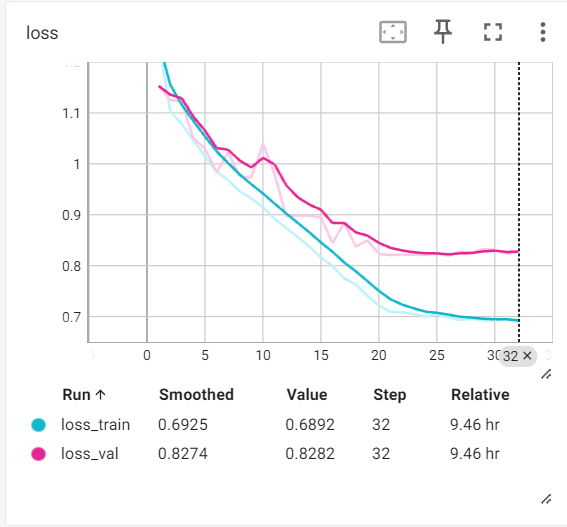
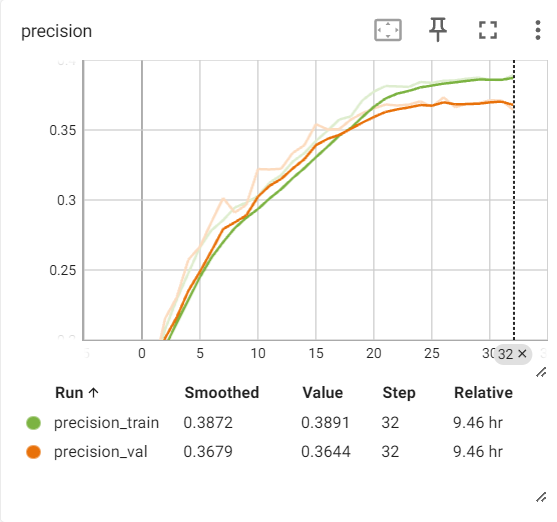
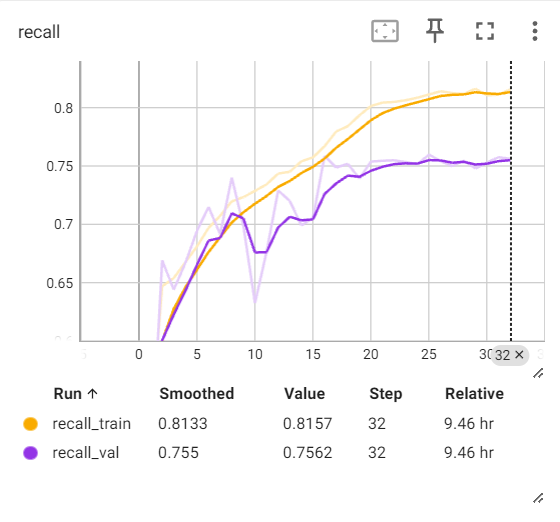
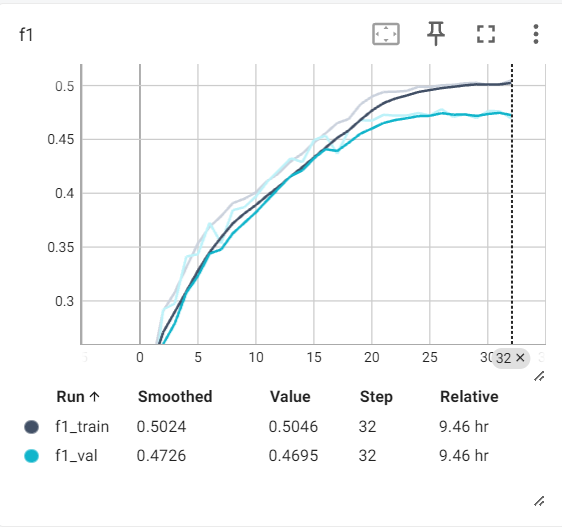

In [27]:
# load model epoch 26
model_name = 'res34_fr_0104/checkpoint_26.pt'
checkpoint = torch.load(config.model_dir/model_name)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [28]:
def predict_with_label(loader, model):
    m = nn.Sigmoid()
    predictions_b = []
    true_labels_b = []
    with torch.no_grad():
        model.eval()
        with tqdm.tqdm(loader, unit="batch",position=0, leave=True) as tepoch:
            for X_batch, y_batch, image_name in tepoch:
                y_hat_batch =  model(X_batch)
                predictions_b.append(m(y_hat_batch))
                true_labels_b.append(y_batch)
    predictions = torch.cat(predictions_b)
    true_labels = torch.cat(true_labels_b)
    return predictions, true_labels

In [29]:
predictions_train, true_labels_train = predict_with_label(train_loader, model)
predictions_valid, true_labels_valid = predict_with_label(valid_loader, model)

100%|██████████| 97/97 [02:19<00:00,  1.44s/batch]


#### Visualize calibration curves
The calibration curves for both the training and validation sets are plotted to evaluate the alignment between the model's predicted probabilities and the actual observed outcomes.

Notably, the calibration curves for class 5 and class 7 closely approach the perfect calibration line. This occurrence can be attributed to the larger sample sizes in these classes, allowing the model to learn more effectively from abundant data. Conversely, the curves for other classes notably deviate below the ideal calibration line, suggesting that the model's predicted probabilities are underconfident. Employing Isotonic Regression may help recalibrate the predicted probabilities for these classes, improving the model's overall calibration performance.

C:\Users\THU\AppData\Local\Temp\ipykernel_13172\2628639891.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


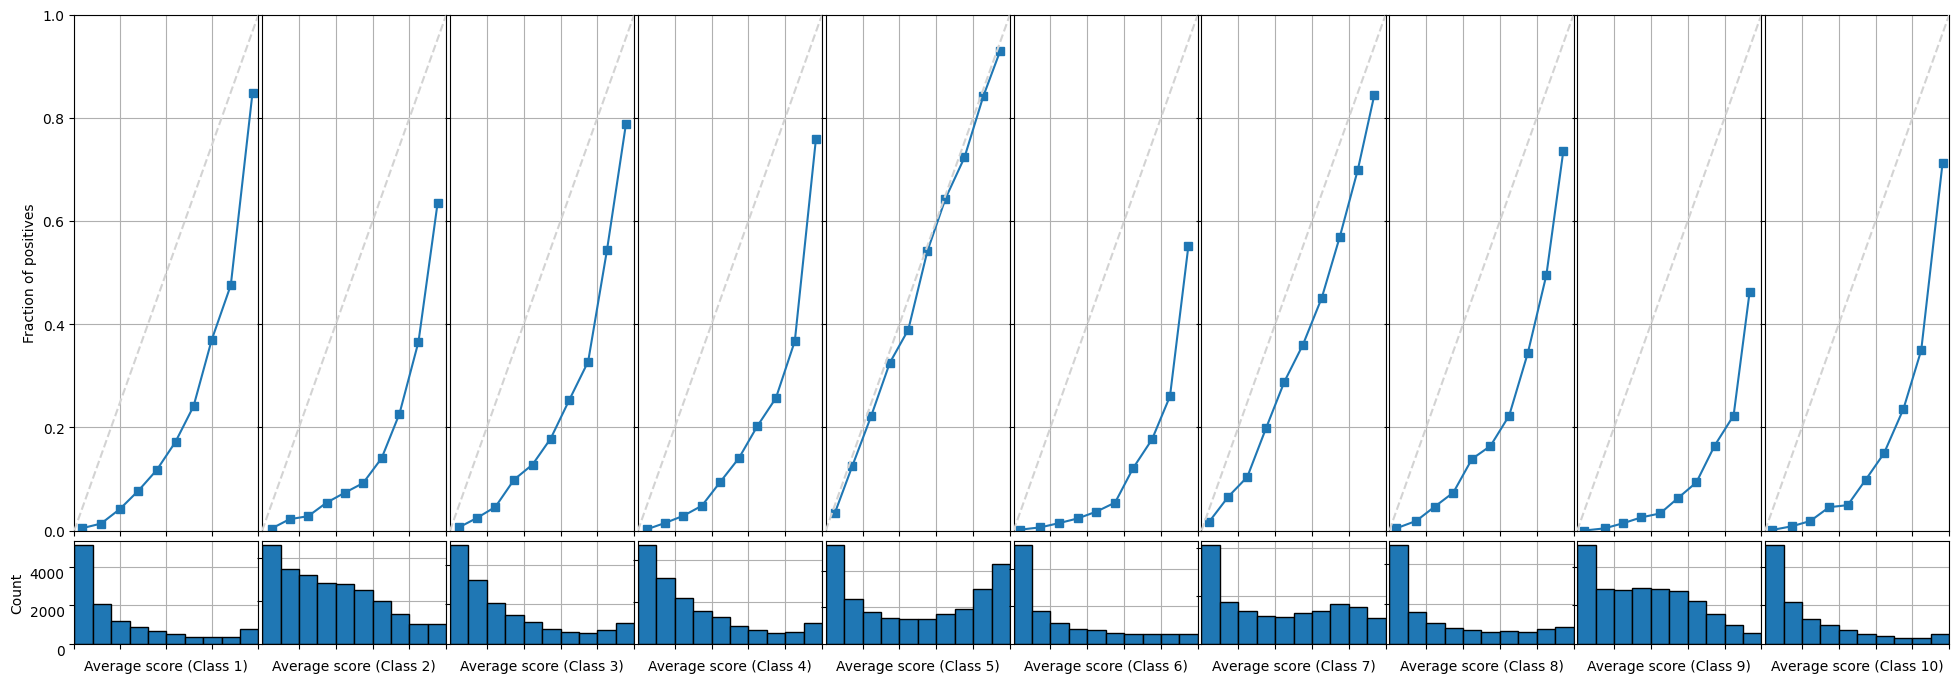

In [30]:
# plot the calibration curve for each class on train set
fig = plt.figure(figsize=(25,10))
scores_list_train = [predictions_train.numpy()]
y_train = true_labels_train.numpy()
_ = plot_reliability_diagram(y_train, scores_list_train, show_histogram=True, fig=fig)
plt.tight_layout()

In [31]:
# train set
conf_ece_list = [conf_ECE(y_train, scores) for scores in scores_list_train]
classwise_ece = [classwise_ECE(y_train, scores) for scores in scores_list_train]

print(f"Confidence ECE: {conf_ece_list[0]:.3f}")
print(f"Classwise ECE: {classwise_ece[0]}")

Confidence ECE: 0.366
Classwise ECE: 0.18292374933410377


C:\Users\THU\AppData\Local\Temp\ipykernel_13172\1307388713.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


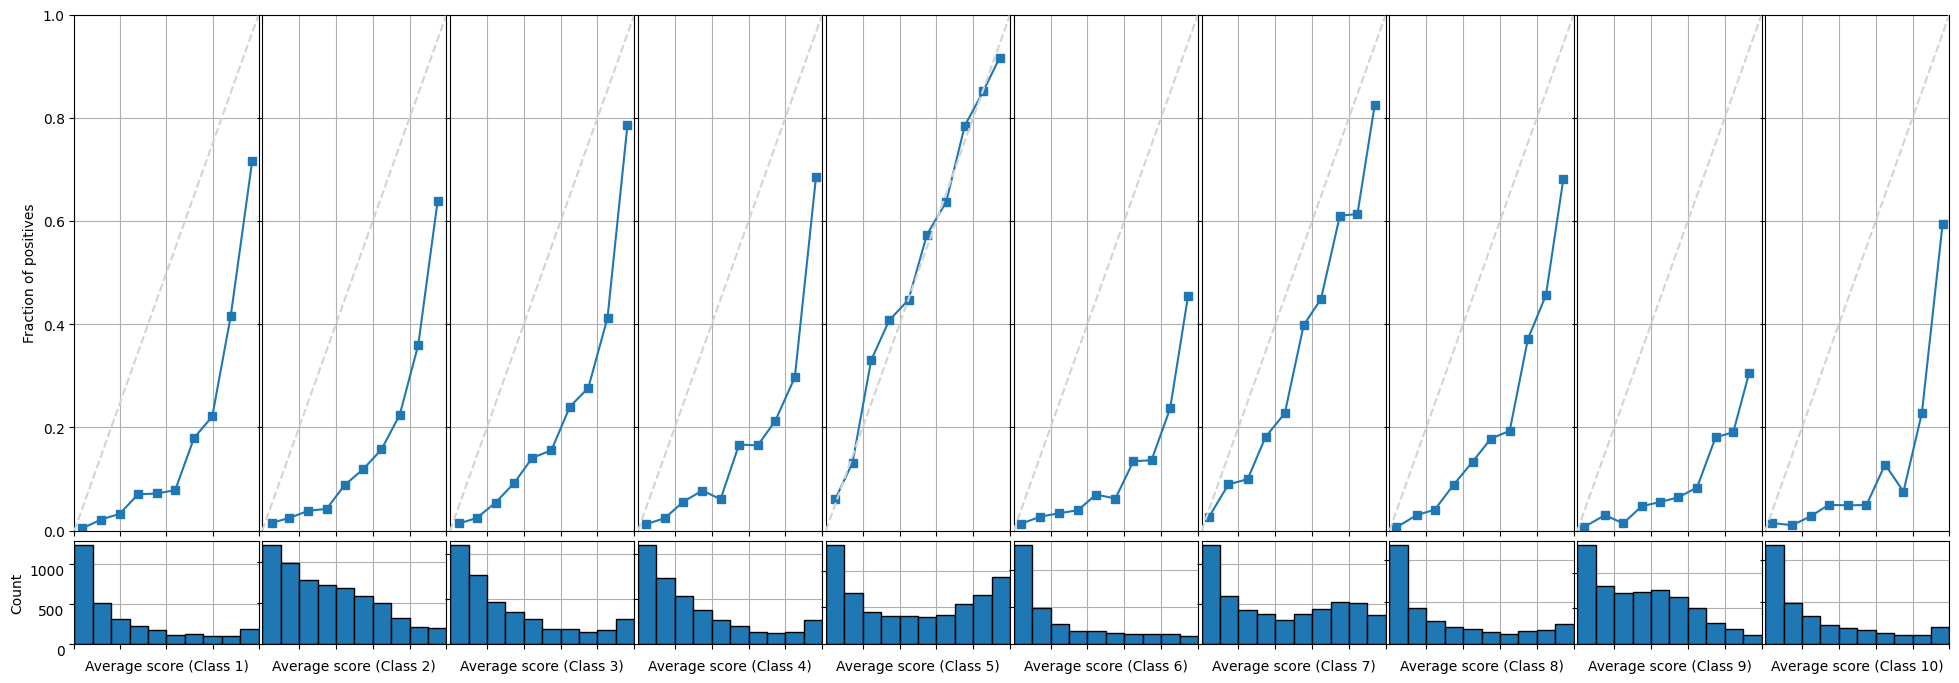

In [32]:
# plot the calibration curve for each class on validation set
fig = plt.figure(figsize=(25,10))
scores_list = [predictions_valid.numpy()]
y_test = true_labels_valid.numpy()
_ = plot_reliability_diagram(y_test, scores_list, show_histogram=True, fig=fig)
plt.tight_layout()

In [33]:
# validation set
conf_ece_list = [conf_ECE(y_test, scores) for scores in scores_list]
classwise_ece = [classwise_ECE(y_test, scores) for scores in scores_list]

print(f"Confidence ECE: {conf_ece_list[0]:.3f}")
print(f"Classwise ECE: {classwise_ece[0]}")

Confidence ECE: 0.408
Classwise ECE: 0.18649901522170992


Prior to selecting thresholds for each class, I fine-tuned the calibration curves using isotonic regression. The model underwent training on the training dataset and was tested on both the validation and test sets. Post curve adjustments, I manually determined thresholds for each class.

This method, while effective, presents a drawback as the threshold selection relies on observational judgment. The attempt was to choose thresholds where the fraction of positives is greater than or equal to 50%. However, due to the imperfect adjustment by isotonic regression, some instances still resulted in zigzagging curves. These deviations may significantly impact the outcome.

In [35]:
# adjust the calibration curve by using isotonic regression
calibrated_train = np.zeros(predictions_train.numpy().shape, dtype=float)
iso_model = {}
for i in range(10):
    iso = IsotonicRegression(out_of_bounds = 'clip')
    proba = predictions_train.numpy()[:,i]
    label = true_labels_train.numpy()[:,i]
    iso.fit(proba,label )
    iso_model[i] = iso
    iso_probs = iso.predict(proba)
    calibrated_train [:,i] = iso_probs

calibrated_valid = np.zeros(predictions_valid.numpy().shape,dtype=float,)
for i in range(10):
    proba = predictions_valid.numpy()[:,i]
    calibrated_valid[:,i] = iso_model[i].predict(proba)


In [36]:
# store the model
with open('../model/iso_calibration.pickle', 'wb') as handle:
    pickle.dump(iso_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

C:\Users\THU\AppData\Local\Temp\ipykernel_13172\1205940366.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


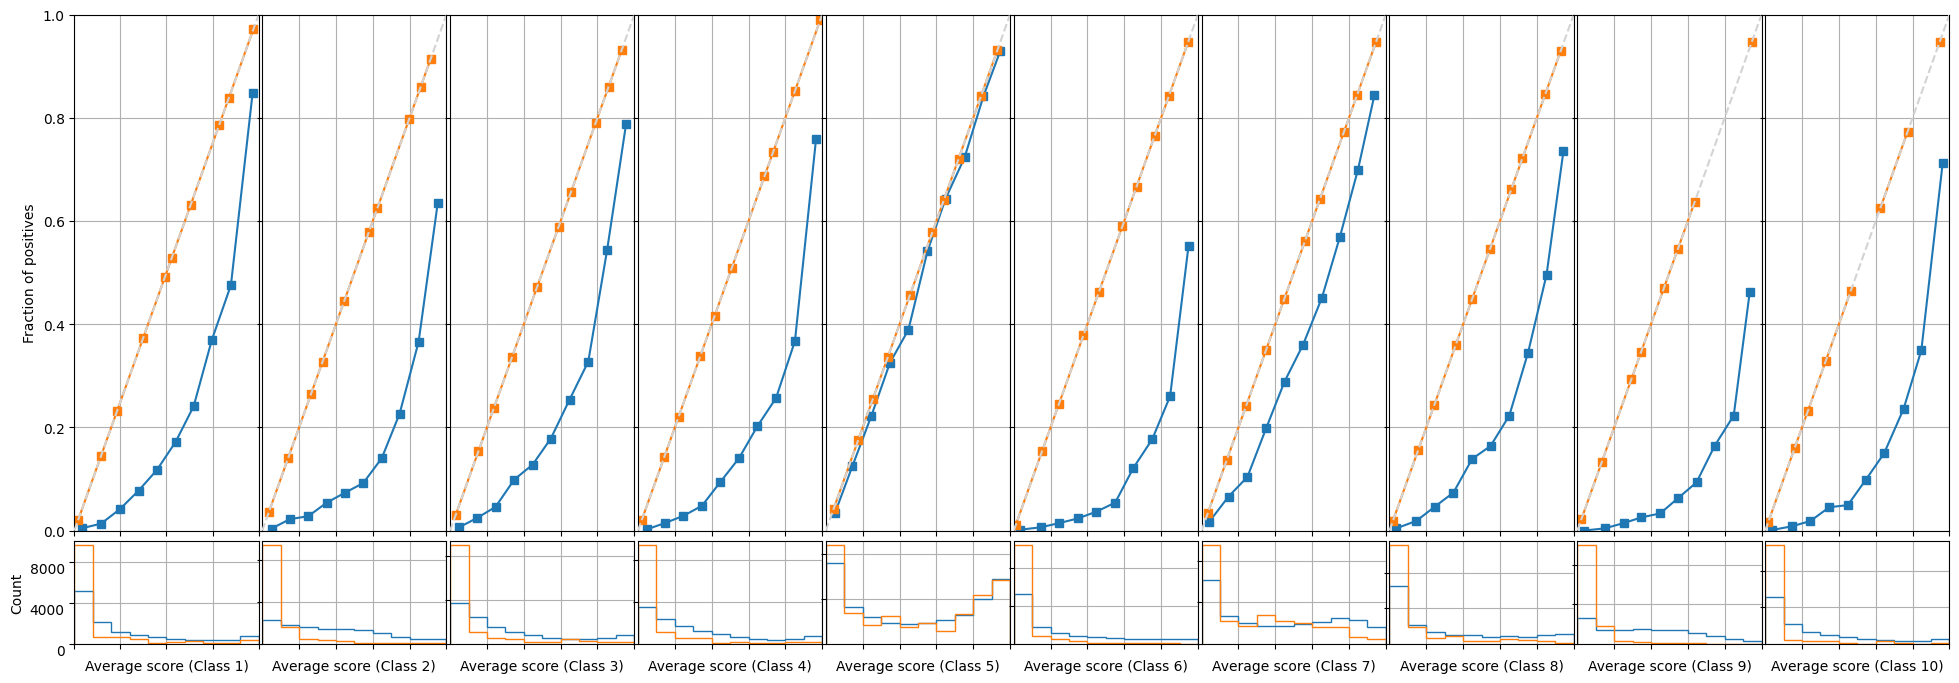

In [37]:
# train set
fig = plt.figure(figsize=(25,10))
scores_list = [predictions_train.numpy(), calibrated_train]
y_test = true_labels_train.numpy()
_ = plot_reliability_diagram(y_test, scores_list, show_histogram=True, fig=fig)
plt.tight_layout()

C:\Users\THU\AppData\Local\Temp\ipykernel_13172\3010749562.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


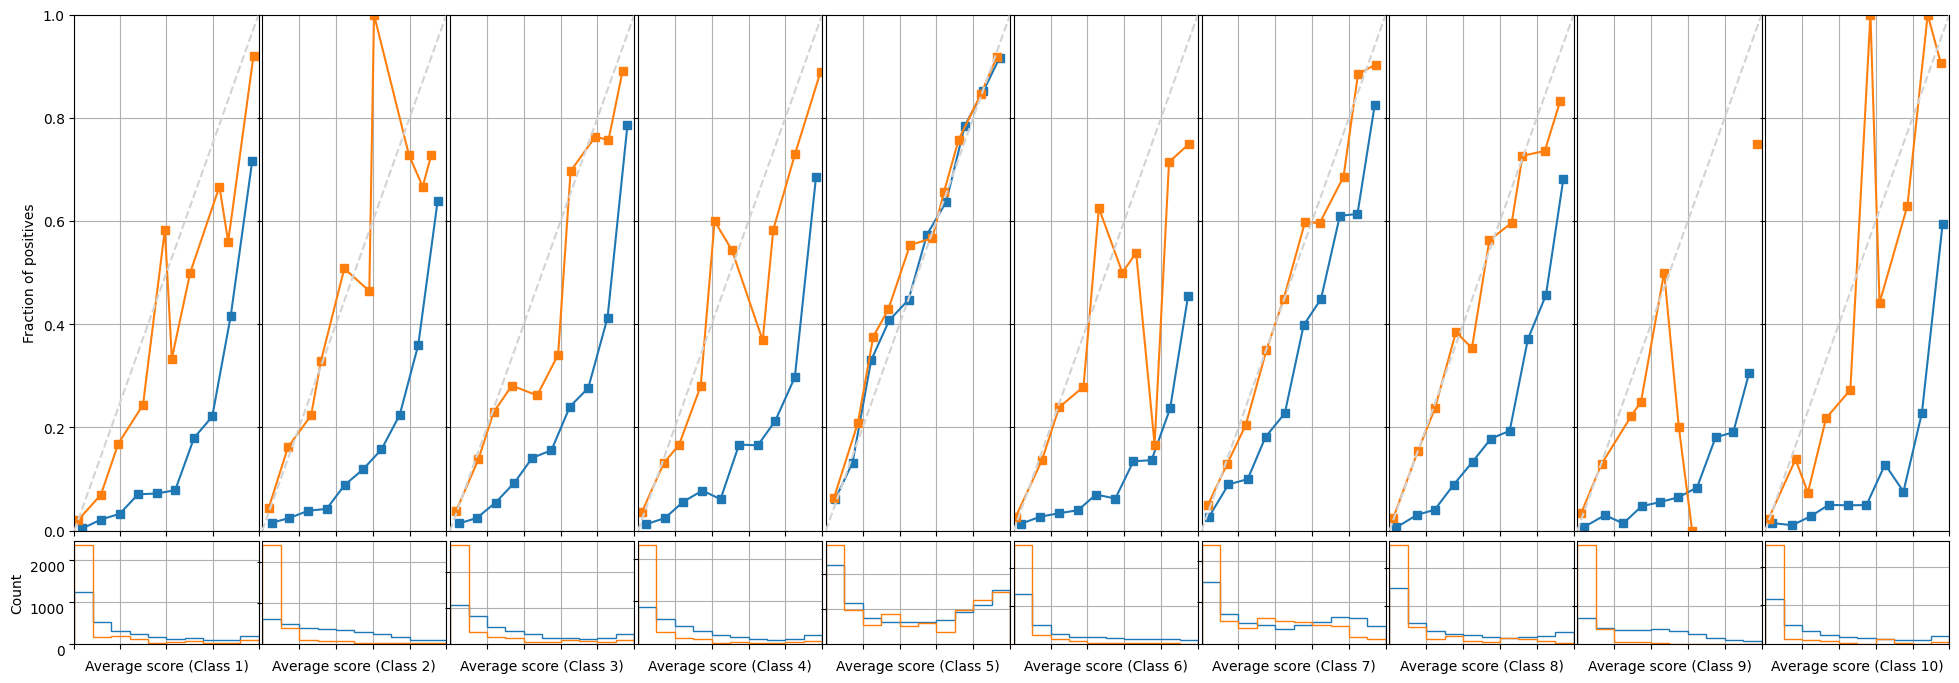

In [38]:
# validation set
fig = plt.figure(figsize=(25,10))
scores_list = [predictions_valid.numpy(), calibrated_valid]
y_test = true_labels_valid.numpy()
_ = plot_reliability_diagram(y_test, scores_list, show_histogram=True, fig=fig)
plt.tight_layout()

In [89]:
# evaluate result
threshold = np.array([0.4, 0.3, 0.6, 0.4, 0.4, 0.2, 0.4, 0.3, 0.2, 0.5])
pred_labels = calibrated_valid > threshold
classification_report(true_labels_valid,pred_labels,output_dict=True,zero_division=0)['macro avg']['f1-score']

0.5389875519563033

After adjusting the calibration curve and setting specific thresholds, the model achieved an F1-score of 0.538 on the evaluation set. Interestingly, maintaining the calibration curve while setting a uniform threshold of 0.5 for all classes resulted in an F1-score of 0.474. This significant variation in performance underlines the substantial impact of changing thresholds for individual classes on the model's effectiveness.

Furthermore, employing data augmentation notably enhanced the model's performance, effectively mitigating overfitting during training.

While the weighted loss function contributed to handling the imbalance issue, there's room for improvement. The effects of imbalanced data persist, evidenced by the calibration curves of classes with fewer samples consistently falling notably below the ideal calibration line. This discrepancy indicates the model's continued underconfidence in these instances.

# Prediction
Execute the model on the test set and store the outcomes.

In [100]:
model_name = 'res34_fr_0104/checkpoint_26.pt'
checkpoint = torch.load(config.model_dir/model_name)
model.load_state_dict(checkpoint['state_dict'])

def predict(loader, model, calibration, threshold):
    m = nn.Sigmoid()
    predictions_b = []
    img_name_b = []
    with torch.no_grad():
        model.eval()
        with tqdm.tqdm(loader, unit="batch",position=0, leave=True) as tepoch:
            for X_batch, img_name in tepoch:
                y_hat_batch =  model(X_batch)
                predictions_b.append(m(y_hat_batch))
                img_name_b.append(img_name)
    predictions = torch.cat(predictions_b).numpy()
    img_names = [item for t in img_name_b for item in t]
    calibrated_pred = np.zeros(predictions.shape,dtype=float,)
    for i in range(10):
        proba = predictions[:,i]
        calibrated_pred[:,i] = calibration[i].predict(proba)
    return calibrated_pred, img_names

In [101]:
with open('../model/iso_calibration.pickle', 'rb') as handle:
    calibration = pickle.load(handle)

threshold = np.array([0.4, 0.3, 0.6, 0.4, 0.4, 0.2, 0.4, 0.3, 0.2, 0.5])

lst_file = []
for file in glob.glob("../data/raw_data/test/*.png"):
    lst_file += [file.split('\\')[-1]]
df_pred = pd.DataFrame(lst_file, columns=['Image'])
test_loader = data_loader(config.test_folder, df_pred, config.N_LABELS, transform=transform, is_train=False, with_label=False)
predictions_test, img_names_test= predict(test_loader, model, calibration, threshold)
pred_labels = predictions_test > threshold

  0%|          | 0/121 [00:00<?, ?batch/s]

100%|██████████| 121/121 [02:53<00:00,  1.43s/batch]


In [95]:
labels = []
for i in range(predictions_test.shape[0]):
    labels += [np.where(pred_labels[i])[0].tolist()]
df = pd.DataFrame({'Image':img_names_test,'Label':labels})
df['Image'] = df['Image'].apply(lambda x: x.split('.')[0])
df['Label'] = [' '.join(map(str, l)) for l in df['Label']]


In [96]:
df.to_csv('result_v2.csv', index=False)